In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
target = "SalePrice"

In [4]:
train = train.drop(['Id'], axis='columns')
test = test.drop(['Id'], axis='columns')

In [5]:
corr = train.set_index(target).reset_index().corr().abs().sort_values(by=target, ascending=False)[target]
corr

C:\Users\D568\AppData\Local\Temp\ipykernel_10468\2655423338.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.set_index(target).reset_index().corr().abs().sort_values(by=target, ascending=False)[target]


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePrice, dtype: float64

목표 변수와 공변량이 높은 변수 몇 개를 골라 이상치를 제거

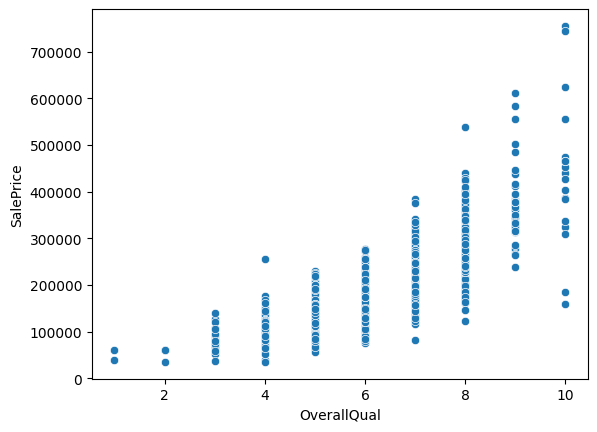

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [6]:
fig, ax = plt.subplots()
sns.scatterplot(x="OverallQual", y=target, data=train)
plt.show()
outlier = train[(train[target] < 200000) & (train['OverallQual'] == 10)]
train = train.drop(outlier.index)
outlier

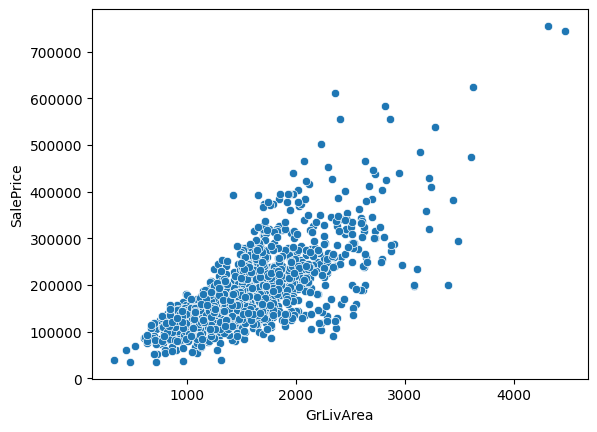

In [7]:
fig, ax = plt.subplots()
sns.scatterplot(x="GrLivArea", y=target, data=train)
plt.show()

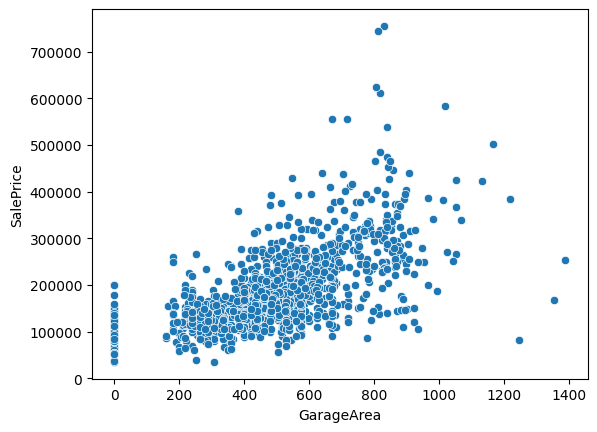

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
581,20,RL,98.0,12704,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2009,New,Partial,253293
1061,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000
1190,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000


In [8]:
fig, ax = plt.subplots()
sns.scatterplot(x="GarageArea", y=target, data=train)
plt.show()
outlier = train[(train[target] < 300000) & (train['GarageArea'] > 1200)]
train = train.drop(outlier.index)
outlier

수영장, 주차장, 지하실 등 시설의 유무로 NA 값들이 생김
GarageX, BsmtX, MasVnrX 값들이 동일한 값들이 동일한 NA값들을 가짐. 해당 변수들의 의존성을 분리할 필요가 있어 보임
매우 많은 NA값을 가지는 Pool, MiscFeature, Alley, Fence 값들과 관련 변수들을 삭제함

FirePlaceQu는 범주형 데이터이기 때문에 'NA'로 채워서 사용

존재하지 않아서 NA값을 채운 특성 중 범주형은 'NA'를 넣고 수치형 데이터는 0을 대입

In [9]:
train_na = train.isna().sum()
train_na = train_na[train_na > 0]
percent = train_na / len(train)
na_df = pd.concat([train_na, percent], axis=1, keys=['count', 'percent']).sort_values('count', ascending=False)
na_df

,count,percent
PoolQC,1449,0.995876
MiscFeature,1402,0.963574
Alley,1364,0.937457
Fence,1174,0.806873
FireplaceQu,689,0.473540
LotFrontage,258,0.177320
GarageType,81,0.055670
GarageYrBlt,81,0.055670
GarageFinish,81,0.055670
GarageQual,81,0.055670


In [10]:
train = train.drop(['PoolQC', 'PoolArea', 'MiscFeature', 'Alley', 'Fence'], axis='columns')
test = test.drop(['PoolQC', 'PoolArea', 'MiscFeature', 'Alley', 'Fence'], axis='columns')

In [11]:
na_df = train.isna().sum()
na_df = na_df[na_df > 0]
na_columns = na_df.index
for col in na_columns:
    if train[col].dtype == 'object':
        train[col] = train[col].fillna('NA')
        test[col] = test[col].fillna('NA')
    else:
        train[col] = train[col].fillna(0)
        test[col] = test[col].fillna(0)


In [12]:
train.isna().sum().max()

0

C:\Users\D568\AppData\Local\Temp\ipykernel_10468\870845909.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


<Axes: >

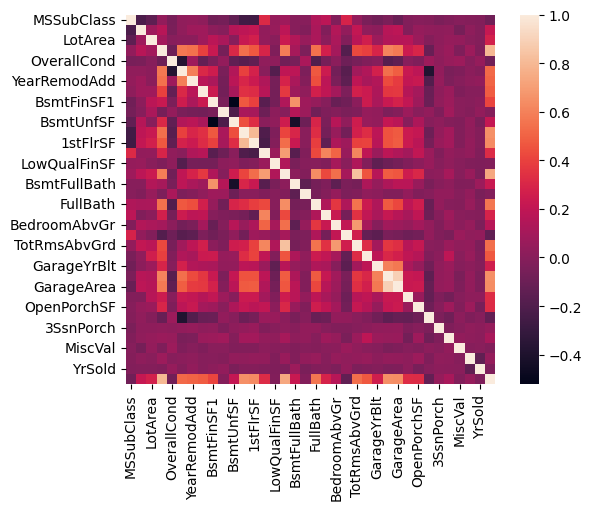

In [13]:
corr_matrix = train.corr()
f, ax = plt.subplots()
sns.heatmap(corr_matrix, vmax=1, square=True)

z_score = (train["SalePrice"] - train["SalePrice"].mean()) / train["SalePrice"].std()
print(len(train))
train = train[z_score.abs().sort_values() < 3]
print(len(train))

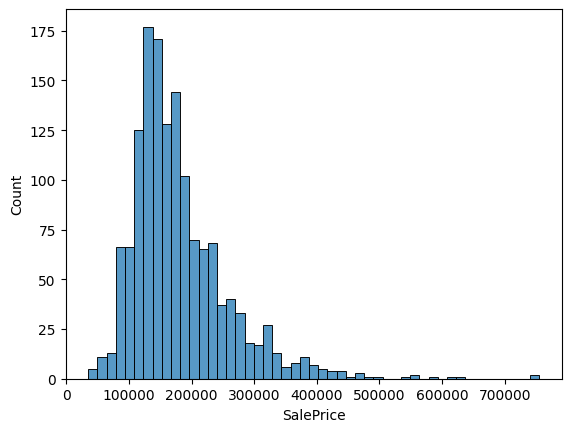

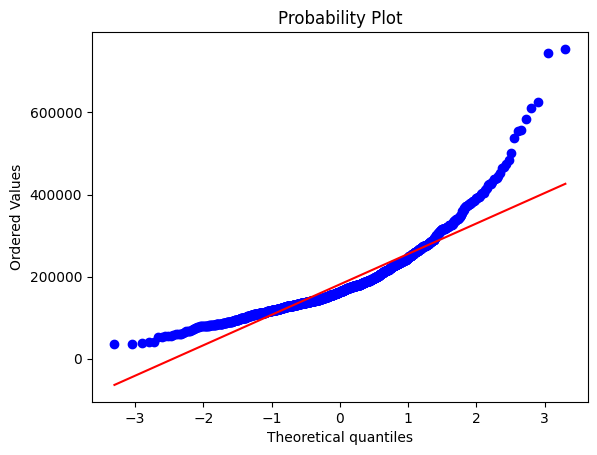

In [14]:
from scipy.stats import norm, probplot


sns.histplot(train['SalePrice'])
fig = plt.figure()
res = probplot(train['SalePrice'], plot=plt)

C:\Users\D568\AppData\Local\Temp\ipykernel_10468\3102713682.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[target])


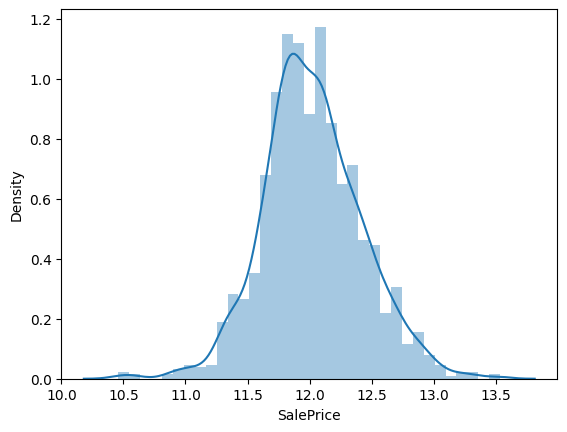

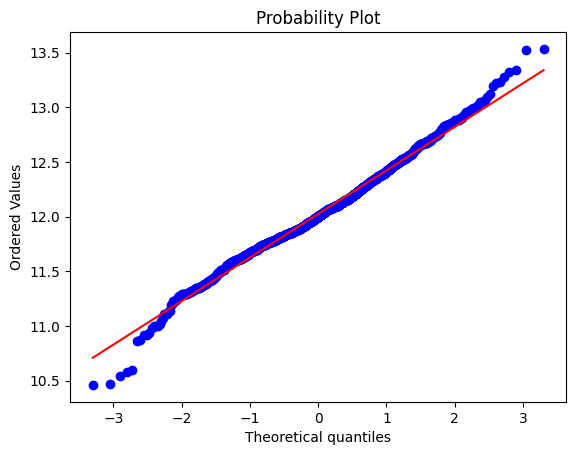

In [15]:
train[target] = np.log(train[target])
sns.distplot(train[target])
fig = plt.figure()
res = probplot(train[target], plot=plt)

In [16]:
numeric_columns = []
for col in train.columns:
    column = train[col]
    if train[col].dtype != 'object':
        numeric_columns.append(col)
print(numeric_columns)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [17]:
new_features = []
length = len(numeric_columns)
for i in range(length - 1):
    for j in range(i + 1, length):
        col1 = numeric_columns[i]
        col2 = numeric_columns[j]
        if col1 == target or col2 == target:
            continue

        new_col = train[col1] * train[col2]
        corr = train.corrwith(new_col).abs().sort_values(ascending=False)
        if target in corr.index[:3]:
            target_index = corr.index[:3].to_list().index(target)
            if corr[target_index] > 0.7:
                new_features.append((col1, col2, corr[target_index]))


C:\Users\D568\AppData\Local\Temp\ipykernel_10468\4065039554.py:11: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corrwith(new_col).abs().sort_values(ascending=False)
C:\Users\D568\AppData\Local\Temp\ipykernel_10468\4065039554.py:11: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corrwith(new_col).abs().sort_values(ascending=False)
C:\Users\D568\AppData\Local\Temp\ipykernel_10468\4065039554.py:11: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


In [18]:
new_features.sort(key=lambda x: x[2], reverse=True)
new_features

[('OverallQual', 'GrLivArea', 0.838204191087063),
 ('OverallQual', 'YearBuilt', 0.828028183733877),
 ('OverallQual', 'YearRemodAdd', 0.8260116387895632),
 ('OverallQual', 'YrSold', 0.8214485756348949),
 ('OverallQual', 'GarageArea', 0.8035642151503163),
 ('GrLivArea', 'GarageCars', 0.8024766183802796),
 ('OverallQual', '1stFlrSF', 0.7963033756896468),
 ('GrLivArea', 'GarageArea', 0.7863208811224643),
 ('OverallQual', 'TotalBsmtSF', 0.7862823931124945),
 ('OverallQual', 'FullBath', 0.7747472921544756),
 ('OverallQual', 'GarageYrBlt', 0.7577072264348662),
 ('GrLivArea', 'GarageYrBlt', 0.7470535040636667),
 ('YearBuilt', 'GrLivArea', 0.7456686947858852),
 ('TotRmsAbvGrd', 'GarageCars', 0.7408935664876002),
 ('YearRemodAdd', 'GrLivArea', 0.7354018091052935),
 ('TotRmsAbvGrd', 'GarageArea', 0.7338258110584822),
 ('1stFlrSF', 'GrLivArea', 0.7264120939852214),
 ('GrLivArea', 'YrSold', 0.7246748337550711),
 ('TotalBsmtSF', 'TotRmsAbvGrd', 0.7246685836860831),
 ('1stFlrSF', 'FullBath', 0.700123

In [19]:
visited = []
greedy = []
for col1, col2, val in new_features:
    if col1 in visited or col2 in visited:
        continue
    visited.append(col1)
    visited.append(col2)
    greedy.append((col1, col2))
greedy

[('OverallQual', 'GrLivArea'),
 ('TotRmsAbvGrd', 'GarageCars'),
 ('1stFlrSF', 'FullBath')]

In [20]:
object_columns = []
numeric_columns = []
for col in train.columns:
    if (train[col].dtype == 'object'):
        object_columns.append(col)
    else:
        numeric_columns.append(col)
print(object_columns)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [21]:
len(train.columns), len(test.columns)

(75, 74)

In [22]:
train = pd.get_dummies(train, columns=object_columns)

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
import lightgbm as lgbm

In [24]:
y_train = train[target]
train = train.drop([target], axis='columns')

In [25]:
n_fold = 5

def rmsle_cv(model):
    kf = KFold(n_fold, shuffle=True)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return rmse

In [26]:
forest = RandomForestRegressor()
_xgb = xgb.XGBRegressor()
_lgbm = lgbm.LGBMRegressor(objective='regression')

In [27]:
forest_score = rmsle_cv(forest)
xg_score = rmsle_cv(_xgb)
lgbm_score = rmsle_cv(_lgbm)

In [28]:
print("forest score: {:.4f}({:.4f})".format(forest_score.mean(), forest_score.std()))
print("xgb score: {:.4f}({:.4f})".format(xg_score.mean(), xg_score.std()))
print("lgbm score: {:.4f}({:.4f})".format(lgbm_score.mean(), lgbm_score.std()))

forest score: 0.1416(0.0135)
xgb score: 0.1355(0.0104)
lgbm score: 0.1266(0.0100)


In [29]:
for i, (c1, c2) in enumerate(greedy):
    train['new_feature_{}'.format(i)] = train[c1] * train[c2]
    test['new_feature_{}'.format(i)] = test[c1] * test[c2]
    train = train.drop([c1, c2], axis='columns')
    test = test.drop([c1, c2], axis='columns')

In [30]:
forest_score = rmsle_cv(forest)
xg_score = rmsle_cv(_xgb)
lgbm_score = rmsle_cv(_lgbm)

In [31]:
print("forest score: {:.4f}({:.4f})".format(forest_score.mean(), forest_score.std()))
print("xgb score: {:.4f}({:.4f})".format(xg_score.mean(), xg_score.std()))
print("lgbm score: {:.4f}({:.4f})".format(lgbm_score.mean(), lgbm_score.std()))

forest score: 0.1366(0.0094)
xgb score: 0.1309(0.0050)
lgbm score: 0.1268(0.0079)
